In [1]:
import torch
import torchvision

import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from PIL import Image

# Choose variants here:

In [2]:
trained_model = False
arch = 'ResNet18'

## System setup:

In [3]:
import inversefed
setup = inversefed.utils.system_startup()
defs = inversefed.training_strategy('conservative')

loss_fn, trainloader, validloader =  inversefed.construct_dataloaders('ImageNet', defs, 
                                                                      data_path='/mnt/ssd4/weiyang/Dataset/')

model = torchvision.models.resnet18(pretrained=False)
kept_weight = model.fc.weight[0].detach().clone()
kept_bias = model.fc.bias[0].detach().clone()
with torch.no_grad():
    model.fc.weight.data = torch.zeros((1000,512), dtype=torch.float)
    model.fc.weight[0] = kept_weight
    model.fc.bias.data = torch.full((1,1000),10000, dtype=torch.float).flatten()
    model.fc.bias[0] = kept_bias
model.to(**setup)
model.eval()

Currently evaluating -------------------------------:
Friday, 18. February 2022 10:05AM
CPUs: 24, GPUs: 2 on chfa01-desktop.
GPU : NVIDIA GeForce RTX 3090


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [4]:
dm = torch.as_tensor(inversefed.consts.imagenet_mean, **setup)[:, None, None]
ds = torch.as_tensor(inversefed.consts.imagenet_std, **setup)[:, None, None]
def plot(tensor):
    tensor = tensor.clone().detach()
    tensor.mul_(ds).add_(dm).clamp_(0, 1)
    if tensor.shape[0] == 1:
        return plt.imshow(tensor[0].permute(1, 2, 0).cpu());
    else:
        fig, axes = plt.subplots(1, tensor.shape[0], figsize=(12, tensor.shape[0]*12))
        for i, im in enumerate(tensor):
            axes[i].imshow(im.permute(1, 2, 0).cpu());

# Reconstruct

### Build the input (ground-truth) gradient

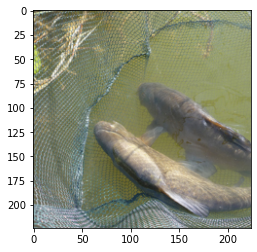

In [34]:
ground_truth = torch.stack([validloader.dataset[50*i][0] for i in range(8)]).to(**setup)
labels = torch.tensor([validloader.dataset[50*i][1] for i in range(8)]).to(**setup)
labels = labels.long()
plot(ground_truth[0].unsqueeze(0));

In [41]:
ground_truth_denormalized = torch.clamp(ground_truth * ds + dm, 0, 1)
torchvision.utils.save_image(ground_truth_denormalized, f'./images/cost_func_ensemble/{idx}_{arch}_ImageNet_input.png')

In [48]:
model.zero_grad()
target_loss, _, _ = loss_fn(model(ground_truth), labels)
input_gradient = torch.autograd.grad(target_loss, model.parameters())
input_gradient = [grad.detach()*8 for grad in input_gradient]
full_norm = torch.stack([g.norm() for g in input_gradient]).mean()
print(f'Full gradient norm is {full_norm:e}.')

Full gradient norm is 3.616731e+00.


It: 0. Rec. loss: 0.6459.
It: 500. Rec. loss: 0.6381.
It: 1000. Rec. loss: 0.6341.
It: 1500. Rec. loss: 0.6330.
It: 2000. Rec. loss: 0.6330.
It: 2500. Rec. loss: 0.6333.
It: 3000. Rec. loss: 0.6329.
It: 3500. Rec. loss: 0.6328.
It: 4000. Rec. loss: 0.6325.
It: 4500. Rec. loss: 0.6327.
It: 5000. Rec. loss: 0.6328.
It: 5500. Rec. loss: 0.6326.
It: 6000. Rec. loss: 0.6322.
It: 6500. Rec. loss: 0.6325.
It: 7000. Rec. loss: 0.6321.
It: 7500. Rec. loss: 0.6322.
It: 8000. Rec. loss: 0.6324.
It: 8500. Rec. loss: 0.6325.
It: 9000. Rec. loss: 0.6323.
It: 9500. Rec. loss: 0.6320.
It: 10000. Rec. loss: 0.6319.
It: 10500. Rec. loss: 0.6316.
It: 11000. Rec. loss: 0.6315.
It: 11500. Rec. loss: 0.6310.
It: 12000. Rec. loss: 0.6311.
It: 12500. Rec. loss: 0.6309.
It: 13000. Rec. loss: 0.6312.
It: 13500. Rec. loss: 0.6311.
It: 14000. Rec. loss: 0.6309.
It: 14500. Rec. loss: 0.6309.
It: 15000. Rec. loss: 0.6308.
It: 15500. Rec. loss: 0.6307.
It: 16000. Rec. loss: 0.6306.
It: 16500. Rec. loss: 0.6305.
It: 

"\ndata = inversefed.metrics.activation_errors(model, output, ground_truth)\n\nfig, axes = plt.subplots(2, 3, sharey=False, figsize=(14,8))\naxes[0, 0].semilogy(list(data['se'].values())[:-3])\naxes[0, 0].set_title('SE')\naxes[0, 1].semilogy(list(data['mse'].values())[:-3])\naxes[0, 1].set_title('MSE')\naxes[0, 2].plot(list(data['sim'].values())[:-3])\naxes[0, 2].set_title('Similarity')\n\nconvs = [val for key, val in data['mse'].items() if 'conv' in key]\naxes[1, 0].semilogy(convs)\naxes[1, 0].set_title('MSE - conv layers')\nconvs = [val for key, val in data['mse'].items() if 'conv1' in key]\naxes[1, 1].semilogy(convs)\nconvs = [val for key, val in data['mse'].items() if 'conv2' in key]\naxes[1, 1].semilogy(convs)\naxes[1, 1].set_title('MSE - conv1 vs conv2 layers')\nbns = [val for key, val in data['mse'].items() if 'bn' in key]\naxes[1, 2].plot(bns)\naxes[1, 2].set_title('MSE - bn layers')\nfig.suptitle('Error between layers');\n"

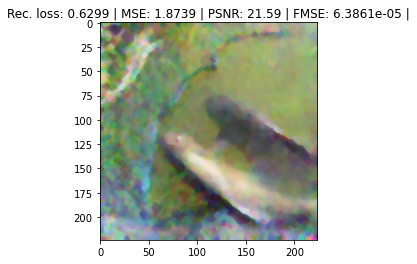

In [58]:
config = dict(signed=True,
              boxed=True,
              cost_fn='sim',
              indices='top10',
              weights='equal',
              lr=0.1,
              optim='adam',
              restarts=1,
              max_iterations=24_000,
              total_variation=1e-6,
              init='randn',
              filter='median',
              lr_decay=True,
              scoring_choice='loss')

rec_machine = inversefed.GradientReconstructor(model, (dm, ds), config, num_images=1)
output, stats = rec_machine.reconstruct(input_gradient, labels[0].unsqueeze(0), img_shape=(3, 224, 224))

test_mse = (output.detach() - ground_truth).pow(2).mean()
feat_mse = (model(output.detach())- model(ground_truth)).pow(2).mean()  
test_psnr = inversefed.metrics.psnr(output, ground_truth, factor=1/ds)

plot(output)
plt.title(f"Rec. loss: {stats['opt']:2.4f} | MSE: {test_mse:2.4f} "
          f"| PSNR: {test_psnr:4.2f} | FMSE: {feat_mse:2.4e} |");

'''
data = inversefed.metrics.activation_errors(model, output, ground_truth)

fig, axes = plt.subplots(2, 3, sharey=False, figsize=(14,8))
axes[0, 0].semilogy(list(data['se'].values())[:-3])
axes[0, 0].set_title('SE')
axes[0, 1].semilogy(list(data['mse'].values())[:-3])
axes[0, 1].set_title('MSE')
axes[0, 2].plot(list(data['sim'].values())[:-3])
axes[0, 2].set_title('Similarity')

convs = [val for key, val in data['mse'].items() if 'conv' in key]
axes[1, 0].semilogy(convs)
axes[1, 0].set_title('MSE - conv layers')
convs = [val for key, val in data['mse'].items() if 'conv1' in key]
axes[1, 1].semilogy(convs)
convs = [val for key, val in data['mse'].items() if 'conv2' in key]
axes[1, 1].semilogy(convs)
axes[1, 1].set_title('MSE - conv1 vs conv2 layers')
bns = [val for key, val in data['mse'].items() if 'bn' in key]
axes[1, 2].plot(bns)
axes[1, 2].set_title('MSE - bn layers')
fig.suptitle('Error between layers');
'''

In [20]:
output_denormalized = torch.clamp(output * ds + dm, 0, 1)
torchvision.utils.save_image(output_denormalized, f'{idx}_{arch}_untrained_output.png')

It: 0. Rec. loss: 0.0507.
It: 500. Rec. loss: 0.0301.
It: 1000. Rec. loss: 0.0196.
It: 1500. Rec. loss: 0.0155.
It: 2000. Rec. loss: 0.0140.
It: 2500. Rec. loss: 0.0133.
It: 3000. Rec. loss: 0.0133.
It: 3500. Rec. loss: 0.0127.
It: 4000. Rec. loss: 0.0133.
It: 4500. Rec. loss: 0.0129.
It: 5000. Rec. loss: 0.0128.
It: 5500. Rec. loss: 0.0123.
It: 6000. Rec. loss: 0.0131.
It: 6500. Rec. loss: 0.0135.
It: 7000. Rec. loss: 0.0126.
It: 7500. Rec. loss: 0.0127.
It: 8000. Rec. loss: 0.0141.
It: 8500. Rec. loss: 0.0130.
It: 9000. Rec. loss: 0.0123.
It: 9500. Rec. loss: 0.0089.
It: 10000. Rec. loss: 0.0084.
It: 10500. Rec. loss: 0.0074.
It: 11000. Rec. loss: 0.0068.
It: 11500. Rec. loss: 0.0068.
It: 12000. Rec. loss: 0.0061.
It: 12500. Rec. loss: 0.0058.
It: 13000. Rec. loss: 0.0056.
It: 13500. Rec. loss: 0.0059.
It: 14000. Rec. loss: 0.0057.
It: 14500. Rec. loss: 0.0058.
It: 15000. Rec. loss: 0.0056.
It: 15500. Rec. loss: 0.0054.
It: 16000. Rec. loss: 0.0046.
It: 16500. Rec. loss: 0.0044.
It: 

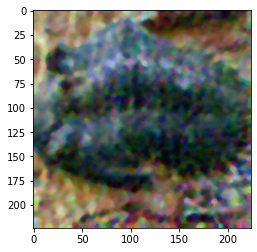

In [46]:
config = dict(signed=True,
              boxed=True,
              cost_fn='sim',
              indices='top10',
              weights='equal',
              lr=0.1,
              optim='adam',
              restarts=1,
              max_iterations=24_000,
              total_variation=1e-6,
              init='randn',
              filter='median',
              lr_decay=True,
              scoring_choice='loss')

rec_machine = inversefed.GradientReconstructor(model, (dm, ds), config, num_images=1)
output1, stats = rec_machine.reconstruct(input_gradient, labels, img_shape=(3, 224, 224))

config = dict(signed=True,
              boxed=True,
              cost_fn='l1',
              indices='top10',
              weights='equal',
              lr=0.1,
              optim='adam',
              restarts=1,
              max_iterations=24_000,
              total_variation=1e-1,
              init='randn',
              filter='median',
              lr_decay=True,
              scoring_choice='loss')

rec_machine = inversefed.GradientReconstructor(model, (dm, ds), config, num_images=1)
output2, stats = rec_machine.reconstruct(input_gradient, labels, img_shape=(3, 224, 224))

config = dict(signed=True,
              boxed=True,
              cost_fn='l2',
              indices='top10',
              weights='equal',
              lr=0.1,
              optim='adam',
              restarts=1,
              max_iterations=24_000,
              total_variation=1e-2,
              init='randn',
              filter='median',
              lr_decay=True,
              scoring_choice='loss')

rec_machine = inversefed.GradientReconstructor(model, (dm, ds), config, num_images=1)
output3, stats = rec_machine.reconstruct(input_gradient, labels, img_shape=(3, 224, 224))

output = weighted_avg([output1, output2, output3], ground_truth)
plot(output)
output_denormalized = torch.clamp(output * ds + dm, 0, 1)
torchvision.utils.save_image(output_denormalized, f'./images/cost_func_ensemble/{idx}_{arch}_untrained_output_ensemble.png')

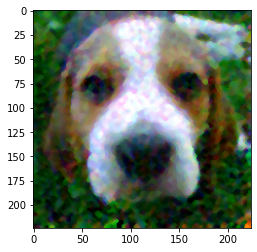

In [16]:
plot(output1)

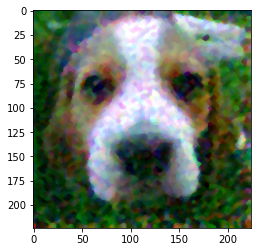

In [17]:
plot(output2)

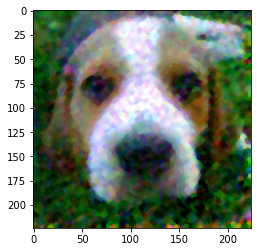

In [18]:
plot(output3)

In [30]:
inversefed.metrics.psnr(output3, ground_truth, factor=1/ds)

19.208309173583984

In [33]:
def weighted_avg(outputs, gt):
    weighted = torch.zeros_like(outputs[0])
    weights = 0
    for output in outputs:
        weight = inversefed.metrics.psnr(output, gt, factor=1/ds)
        weights += weight
        weighted += weight*output
    return weighted/weights

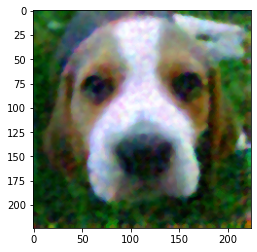

In [39]:
plot(weighted_avg([output1, output2, output3], ground_truth))